# Práctica 6 - Claudio Esteban & Nicolás Corsini

## Entrenamiento del Modelo

In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

### Separación de datos

Se guardan los 8000 primeros datos para el training y el test.
El resto se utilizará para evaluar el modelo.

In [42]:
# Data Loading


#training data
data_train_total = pd.read_excel("CCPP.xlsx", sheet_name='Sheet1')
data_train_total.head()

data_train = data_train_total[0:8000]
data_test = data_train_total[8001:]

In [43]:
data_train.info()
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      8000 non-null   float64
 1   V       8000 non-null   float64
 2   AP      8000 non-null   float64
 3   RH      8000 non-null   float64
 4   PE      8000 non-null   float64
dtypes: float64(5)
memory usage: 312.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 8001 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      1567 non-null   float64
 1   V       1567 non-null   float64
 2   AP      1567 non-null   float64
 3   RH      1567 non-null   float64
 4   PE      1567 non-null   float64
dtypes: float64(5)
memory usage: 61.3 KB


Text(0.5, 0, 'PE')

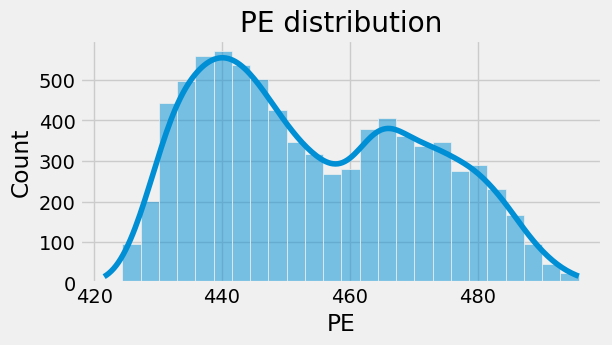

In [11]:
# Distribution of the output variable
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data_train, x='PE', kde=True,ax=ax)
ax.set_title("PE distribution")
ax.set_xlabel('PE')

In [48]:
# Normalization and new df
scaler = MinMaxScaler()
scaler.fit(data_train)
print(data_train)
data= scaler.transform(data_train)

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
7995  15.73  38.73  1002.48  76.91  466.63
7996  16.22  41.35  1000.96  79.59  462.21
7997  27.44  47.93  1002.71  59.44  437.76
7998  25.51  64.27  1013.28  61.85  444.76
7999  19.14  56.65  1020.84  82.97  458.06

[8000 rows x 5 columns]


In [13]:
df=pd.DataFrame(data, columns=data_train.columns)

In [14]:
# Configuring train and test datasets
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "PE"),
                                        df['PE'],
                                        random_state = 123,
                                        shuffle      = True
                                    )

In [15]:
# Checking training and test datasets

print("Training dataset")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
#display(X_train.describe(include = 'object'))
print(" ")

print("Test dataset")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
#display(X_test.describe(include = 'object'))

Training dataset
-----------------------


count    6000.000000
mean        0.443098
std         0.230685
min         0.047715
25%         0.245653
50%         0.402750
75%         0.633138
max         1.000000
Name: PE, dtype: float64

,AT,V,AP,RH
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.504853,0.515383,0.499701,0.638385
std,0.211681,0.225699,0.149753,0.195366
min,0.000000,0.000000,0.000000,0.000000
25%,0.332224,0.291459,0.395536,0.506227
50%,0.523513,0.480427,0.492123,0.661169
75%,0.677054,0.732206,0.600900,0.793625
max,1.000000,1.000000,1.000000,0.999865


 
Test dataset
-----------------------


count    2000.000000
mean        0.440404
std         0.230365
min         0.000000
25%         0.243833
50%         0.401806
75%         0.634317
max         0.992587
Name: PE, dtype: float64

,AT,V,AP,RH
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.507236,0.510914,0.498031,0.634141
std,0.210302,0.228078,0.146662,0.199850
min,0.056941,0.000000,0.021505,0.010502
25%,0.330807,0.287900,0.397162,0.494345
50%,0.536969,0.459609,0.491248,0.654773
75%,0.678895,0.732740,0.597899,0.788912
max,0.930312,0.975445,0.997249,1.000000


La elección de los parámetros para la búsqueda de hiperparámetros para nuestro modelo , es crucial para obtener un buen rendimiento del  mismo.

1. hidden_layer_sizes: Este parámetro determina la arquitectura de la red neuronal, estableciendo cuántas capas ocultas tiene y cuántas neuronas hay en cada capa. Se proponen diferentes configuraciones de capas ocultas con diferentes tamaños (10, 20, 30, (10, 10)) para explorar una variedad de estructuras de red y encontrar la que mejor se adapte a la complejidad del problema en estudio.
2. alpha: Este parámetro controla la fuerza de regularización en la red neuronal, que ayuda a prevenir el sobreajuste penalizando los pesos grandes en la red. En este caso se utiliza una escala logarítmica de valores desde 0.001 hasta 1000 para explorar una amplia gama de fuerzas de regularización, para encontrar el equilibrio adecuado. 
3. learning_rate_init: Este parámetro define la tasa de aprendizaje inicial para la actualización de los pesos de la red neuronal durante el entrenamiento, para garantizar una convergencia rápida y estable durante el entrenamiento.  En este caso se prueban dos valores diferentes, 0.001 y 0.01, para explorar diferentes velocidades de aprendizaje y encontrar la más adecuada para el conjunto de datos.

In [16]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'model__hidden_layer_sizes': [(10), (20), (30), (10, 10)],
    'model__alpha': np.logspace(-3, 3, 10),
    'model__learning_rate_init': [0.001, 0.01],
}

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('model', MLPRegressor(solver = 'adam', max_iter= 1000))]) # Altenative solver lbfgs or sgd

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 100,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 10, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_model__learning_rate_init,param_model__hidden_layer_sizes,param_model__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
15,0.01,"(10, 10)",0.004642,-0.003309,0.000383,-0.003319,0.000126
23,0.01,"(10, 10)",0.021544,-0.003309,0.000370,-0.003286,0.000089
5,0.01,30,0.001,-0.003334,0.000335,-0.003316,0.000162
21,0.01,30,0.021544,-0.003357,0.000432,-0.003358,0.000282
19,0.01,20,0.021544,-0.003372,0.000450,-0.003315,0.000143
11,0.01,20,0.004642,-0.003374,0.000398,-0.003339,0.000144
29,0.01,30,0.1,-0.003383,0.000432,-0.003391,0.000150
13,0.01,30,0.004642,-0.003385,0.000390,-0.003357,0.000119
27,0.01,20,0.1,-0.003401,0.000380,-0.003359,0.000113
3,0.01,20,0.001,-0.003402,0.000406,-0.003379,0.000174


In [17]:
# best model selected

model_final = grid.best_estimator_

In [18]:
# showing the characteristics of the best model found
model_final['model'].get_params()

{'activation': 'relu',
 'alpha': 0.004641588833612777,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10, 10),
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [19]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


R2 Value in training: 0.94
Accuracy in training 85.07


Se obtiene una precisión en el modelo entrenado del 85%

### Testing del modelo

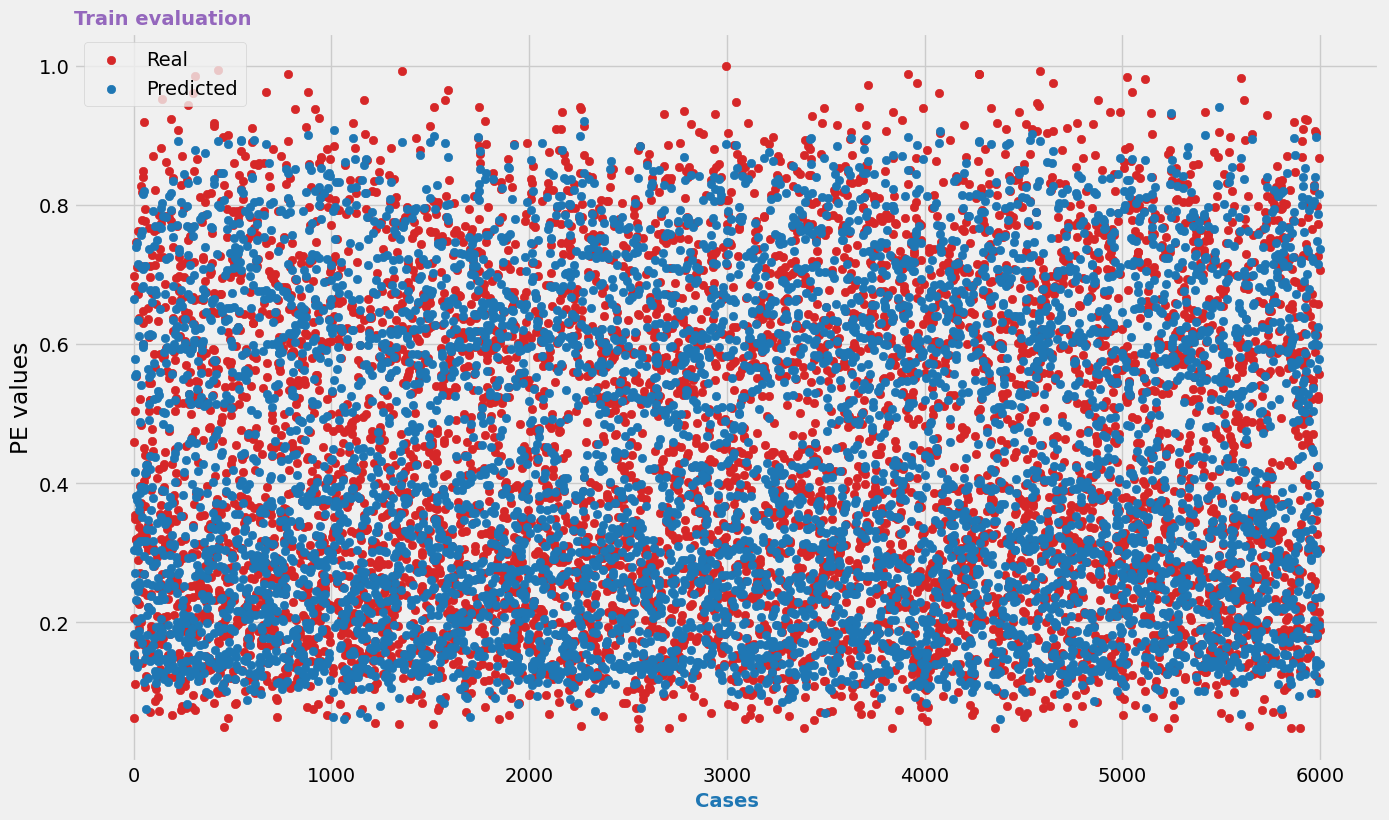

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("PE values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

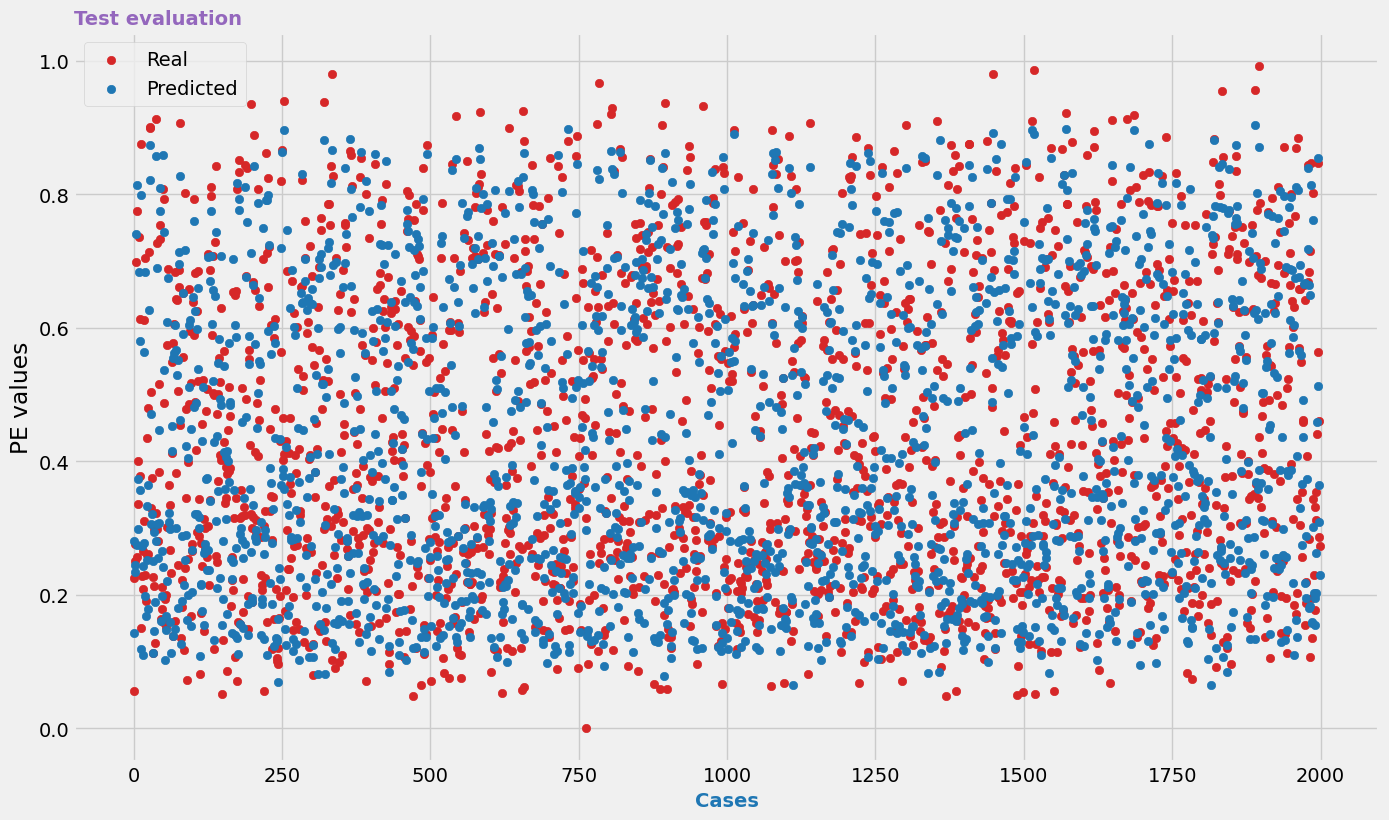

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("PE values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

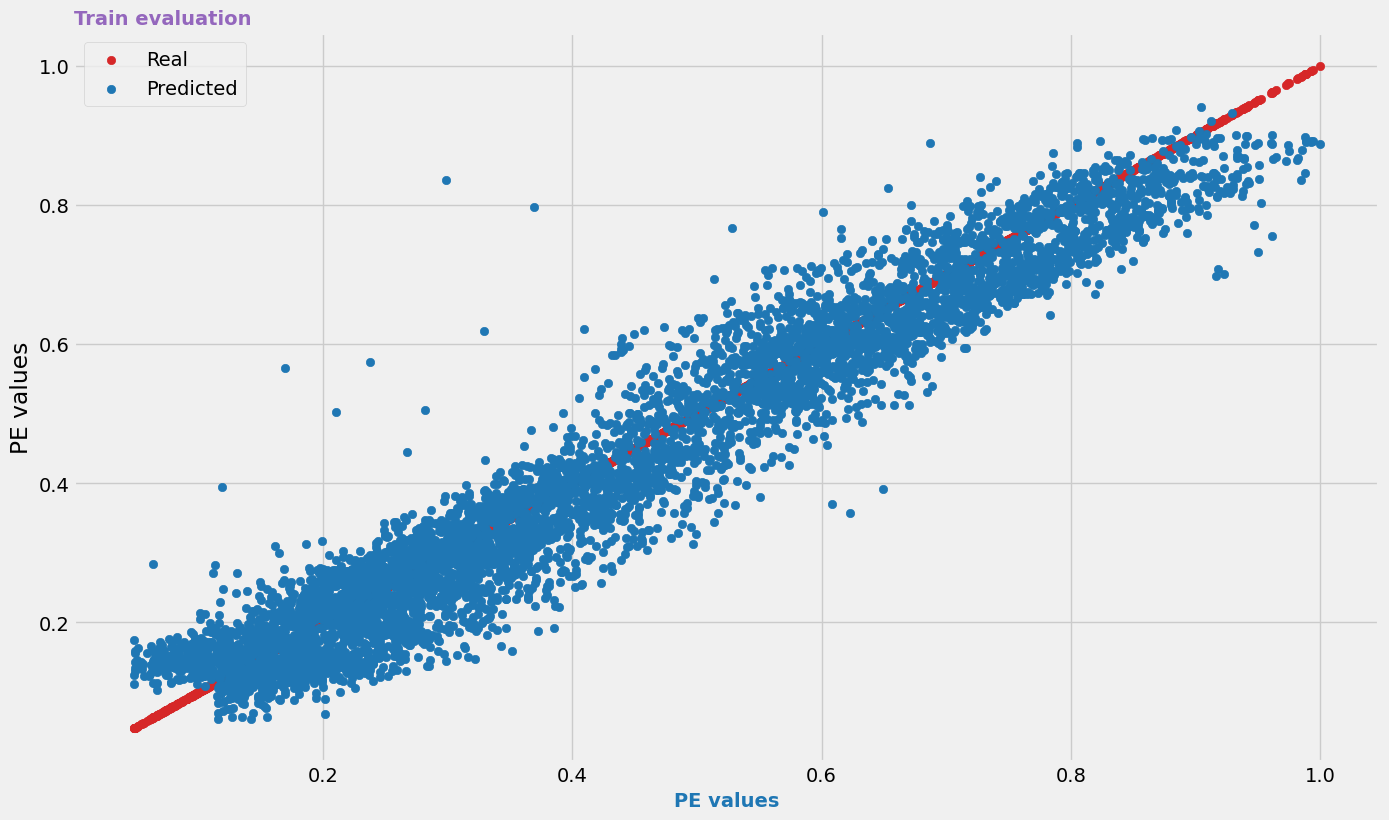

In [36]:
import matplotlib.pyplot as plt  # TRAINING

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("PE values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("PE values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

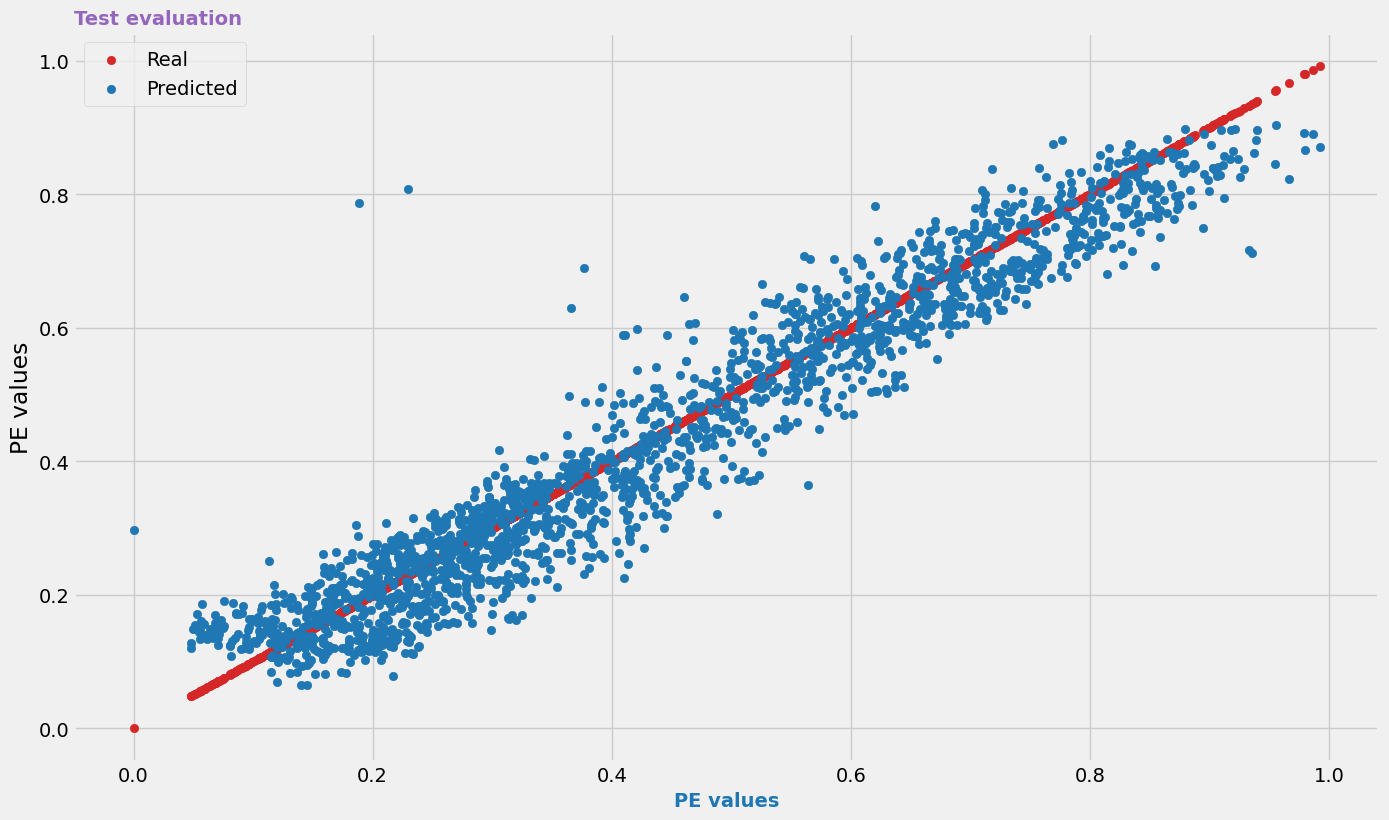

In [40]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("PE values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("PE values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

Como se puede ver, los resultados de las predicciones se ajustan con considerable precisión a los reales

<Axes: xlabel='PE', ylabel='Density'>

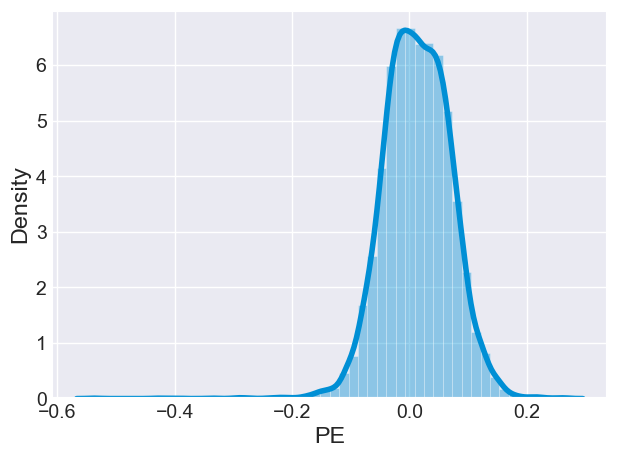

In [41]:
# Error in training
sns.set_style('darkgrid')
sns.distplot(y_train-prediction_train)

Como se puede observar, el error en las predicciones es una normal centrada en el 0. Esto muestra que los errores son reducidos

## Evaluación del Modelo

Se cogen los 1560 datos que no se han utilizado previamente. Estos se emplean ahora para evaluar la precisión del modelo

Para ello, primero se normalizan. Después, se elimina la columna "PE", y se introducen los datos en el modelo. El modelo predice los valores de la columna "PE". Por último, se comparan estos valores con los originales

In [56]:
scaler = MinMaxScaler()
scaler.fit(data_test)
data_test_norm= scaler.transform(data_test)
data_test_norm=pd.DataFrame(data_test_norm, columns=data_test.columns)
predictions_norm = model_final.predict(data_test_norm.drop(columns="PE"))


df_predicted_norm = data_test_norm.drop(columns="PE")
df_predicted_norm["PE"] = predictions_norm

df_predicted = scaler.inverse_transform(df_predicted_norm)
df_predicted=pd.DataFrame(df_predicted, columns=data_test.columns)

predictions = list(df_predicted["PE"])
expected = list(data_test["PE"])

print(predictions)
print(expected)

[464.68211031558917, 456.3519257333104, 425.2595733147916, 464.0934575185724, 461.73368287416434, 472.48206346142575, 451.4431824557254, 442.3271363696262, 430.5153501976315, 453.64412373398585, 428.7755381756443, 476.44866528353725, 445.4875291392692, 440.3315493020397, 428.31754918349174, 470.7819482428874, 476.40242734140446, 438.1283093938595, 465.18929078561655, 448.9821750321804, 444.37299721857266, 461.98416128190775, 447.6811565393094, 480.2651918795245, 429.64237717446383, 433.38380973592626, 431.2339263044571, 432.71510929929235, 441.4013338970011, 436.38722384059884, 454.41823683860395, 461.8657556742701, 436.54256258582245, 433.79086135648964, 462.8541040948602, 456.5112061680431, 440.945814886526, 437.3191974247074, 448.5798513071013, 484.71992329325644, 450.12770324724346, 482.3821756183543, 459.62140542404165, 483.32973946842577, 425.8250993127942, 435.1246836048868, 433.6248567218306, 443.6437015202607, 465.50920755218766, 450.2049766613085, 476.2391291058223, 468.34939

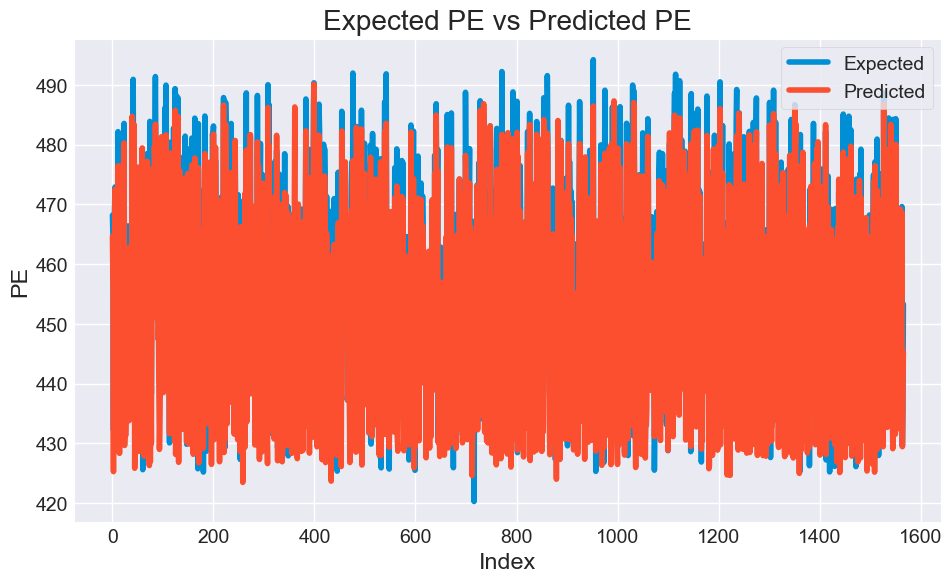

In [58]:
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(10, 6)) 

plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')

plt.xlabel('Index')  
plt.ylabel('PE')
plt.title('Expected PE vs Predicted PE')

plt.legend()

plt.show()


Como se puede ver, los resultados de las predicciones cuadran correctamente con los valores originales

## Model Accuracy

In [63]:
errors = []
for index, expected_value in enumerate(expected):
    predicted_value = predictions[index]
    error = (np.abs(expected_value-predicted_value)/expected_value)*100
    errors.append(error)

mean_error = round(np.mean(errors), 2)
print(f"Mean Error: {str(mean_error)} %" )

print('R2 Value:', round(metrics.r2_score(expected, predictions),2))


Mean Error: 1.01 %
R2 Value: 0.89


El modelo presenta un error medio de 1% en las predicciones, lo que es aceptable. Además, su R2 score es alto, del 89%

En conclusión, los resultados obtenidos son válidos, por lo que la elección de los parámetros para el ajuste de los hiperparámetros se da por buena.